# MLP for Correlation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

%matplotlib inline

Using TensorFlow backend.


In [2]:
#Importing the Dataset
dataset = pd.read_csv('2021_10_31_cleaned_lake_dataset_with_tds.csv', header=0, index_col=0)
dataset = dataset.rename(columns={'actual_conductivity':'cond', 'total_dissolved_solids':'tds', 'do_concentration':'do', 'turbidity':'turb', 'chl-a_concentration':'chl-a', 'temperature':'temp'})
dataset = dataset[['temp', 'cond', 'do', 'tds', 'turb', 'chl-a']]
dataset.sort_index()
dataset.head()

,temp,cond,do,tds,turb,chl-a
datetime,,,,,,
2019-02-20 12:00:00,29.55674,92.12651,6.491213,0.055088,32.86783,39.64875
2019-02-20 12:10:00,29.59175,92.22813,6.724226,0.055115,24.30492,40.57396
2019-02-20 12:20:00,29.57693,91.93182,6.677357,0.054952,47.46174,40.88269
2019-02-20 12:30:00,29.63118,92.45161,7.540924,0.055210,55.04100,46.67803
2019-02-20 12:40:00,29.64378,92.78736,7.629431,0.055398,26.58170,47.05107


In [3]:
#Sanity Check
missing_summary= dataset.isna().sum()
print(missing_summary)

temp     0
cond     0
do       0
tds      0
turb     0
chl-a    0
dtype: int64


In [4]:
#Dataset Stats
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,8516.0,30.033648,0.613371,28.474770,29.622605,30.116715,30.463680,31.595630
cond,8516.0,99.561995,8.891243,71.087590,94.474533,98.563085,105.827075,125.575600
do,8516.0,6.139510,2.277367,0.115000,4.388463,6.196976,7.700019,13.116540
tds,8516.0,0.059048,0.005393,0.042957,0.055888,0.058087,0.062871,0.075244
turb,8516.0,82.244682,54.427438,9.632318,42.198635,66.794560,106.602300,272.187000
chl-a,8516.0,276.399605,264.205888,24.960230,60.750943,205.356200,347.067525,1126.180000


Text(0.5, 1.08, 'Pair Plot of Six Water Quality Parameters')

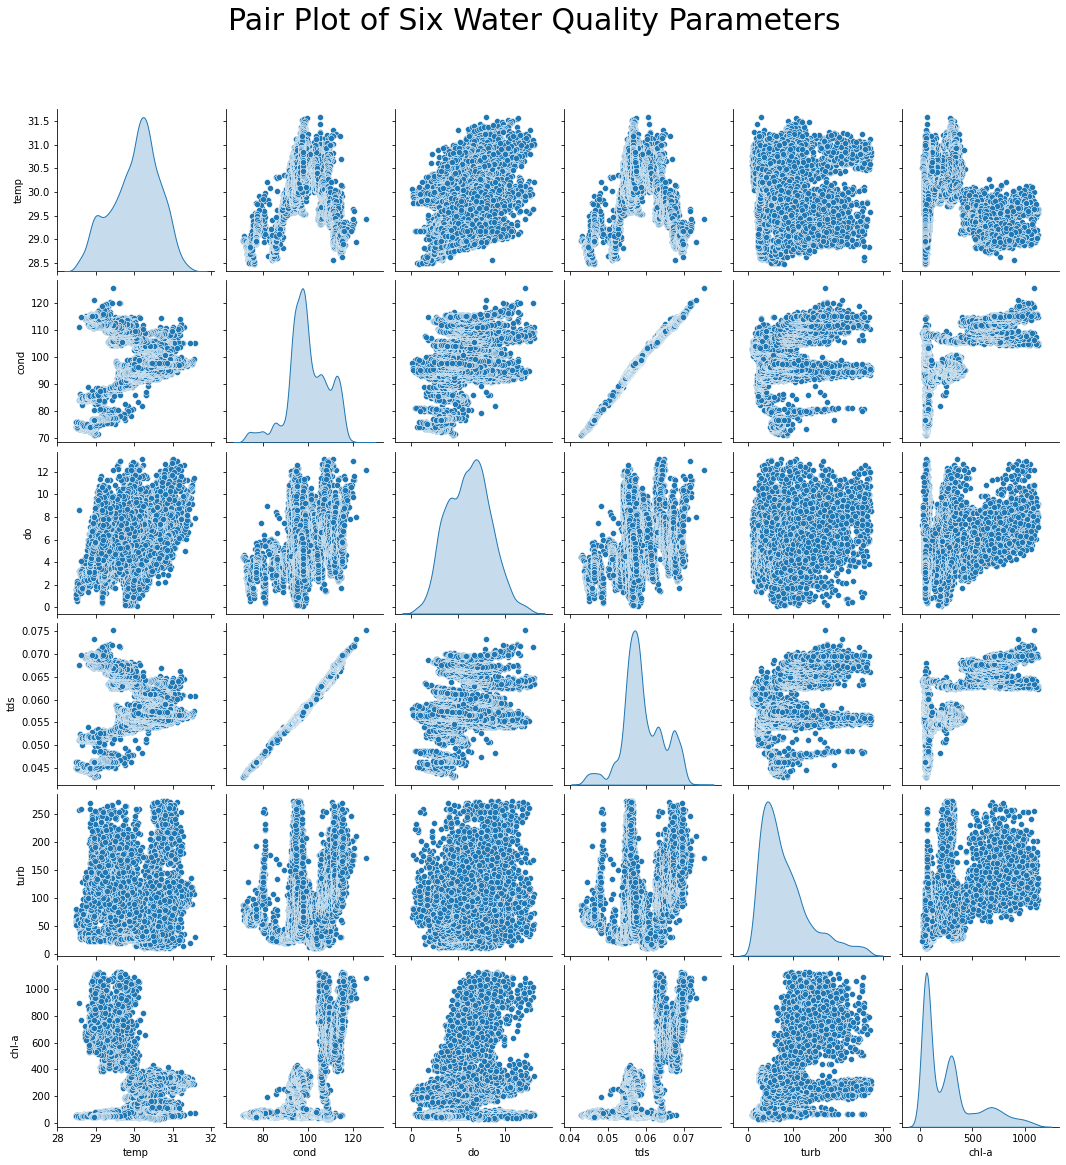

In [6]:
#Pair Plot in SNS
g = sns.pairplot(dataset[['temp', 'cond', 'do', 'tds', 'turb', 'chl-a']], diag_kind="kde")
g.fig.suptitle("Pair Plot of Six Water Quality Parameters", y=1.08, fontsize = 30) # y= some height>1

#Trying on both trimmed and untrimmed
# trimmed_dataset = dataset[:] #['2019-02-20' : '2019-04-05']
# trimmed_dataset.tail()
# print(trimmed_dataset.shape)

In [100]:
#Data Preprocessing
#Ascertain all data is float
values = trimmed_dataset.values

values = values.astype('float32')

#Normalizing Features
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values)
# scaled_df = pd.DataFrame(scaled_data)
# scaled_df.tail()
print(values.shape)

(8516, 5)


In [110]:
#Splitting Dataset into Inputs and Outputs

n_train = 6816 #80% train

train = values[:n_train, :]
test = values[n_train:,:]

train_X = train[:,:-1]
train_y = train[:,-1]

test_X = test[:,:-1]
test_y = test[:,-1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(6816, 1, 4) (6816,) (1700, 1, 4) (1700,)


In [111]:

#create model
model = Sequential()
model.add(Dense(4, input_shape=(train_X.shape[1], train_X.shape[2]), kernel_initializer= 'normal', activation = 'tanh'))
#model.add(Dense(128, kernel_initializer= 'normal', activation = 'sigmoid'))
model.add(Dense(64, kernel_initializer= 'normal', activation = 'sigmoid'))
model.add(Dense(64, kernel_initializer= 'normal', activation = 'sigmoid'))
model.add(Dense(1, kernel_initializer = 'normal'))
#compile model
model.compile(loss = 'mae' , optimizer = 'adam')
model.summary()


Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 1, 4)              20        
_________________________________________________________________
dense_78 (Dense)             (None, 1, 64)             320       
_________________________________________________________________
dense_79 (Dense)             (None, 1, 64)             4160      
_________________________________________________________________
dense_80 (Dense)             (None, 1, 1)              65        
Total params: 4,565
Trainable params: 4,565
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
385/385 - 1s - loss: 139.4183 - val_loss: 669.4131
Epoch 2/100
385/385 - 0s - loss: 112.9820 - val_loss: 643.0045
Epoch 3/100
385/385 - 0s - loss: 96.5452 - val_loss: 630.4013
Epoch 4/100
385/385 - 0s - loss: 94.3072 - val_loss: 625.6562
Epoch 5/100
385/385 - 0s - loss: 93.9820 - val_loss: 622.7968
Epoch 6/100
385/385 - 0s - loss: 93.9001 - val_loss: 621.2990
Epoch 7/100
385/385 - 0s - loss: 93.8799 - val_loss: 620.5435
Epoch 8/100
385/385 - 0s - loss: 93.2896 - val_loss: 616.3332
Epoch 9/100
385/385 - 0s - loss: 90.5611 - val_loss: 603.8649
Epoch 10/100
385/385 - 0s - loss: 87.9800 - val_loss: 591.4388
Epoch 11/100
385/385 - 0s - loss: 85.6867 - val_loss: 579.0734
Epoch 12/100
385/385 - 0s - loss: 83.5192 - val_loss: 565.2919
Epoch 13/100
385/385 - 0s - loss: 81.3311 - val_loss: 553.5833
Epoch 14/100
385/385 - 0s - loss: 79.2376 - val_loss: 539.6286
Epoch 15/100
385/385 - 0s - loss: 76.9347 - val_loss: 526.2061
Epoch 16/100
385/385 - 0s - loss: 75.1801 - val_loss: 511.8544

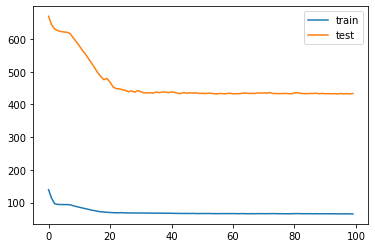

In [112]:
#Fitting the model
history = model.fit(X, Y, epochs=100, batch_size = 16, validation_data = (test_X, test_y), verbose=2, shuffle=True)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()